# Import statements

(You likely do not have to change this)

In [1]:
import numpy as np
import scipy
from scipy.integrate import ode
import networkx as nx
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc
rc('animation', html='html5')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Markdown description of model

For example:

$$\mathbf{v} = \frac{d\mathbf{x}}{dt}$$
$$\frac{d\mathbf{v}}{dt} = -a\mathbf{x} -b\mathbf{v} + W_r tanh(\mathbf{x}) + W_I F(t)$$

$W_r$ is recurrent weight matrix, diagonal set to zero

$W_I$ is external force weight vector

# Differential equations


## Simple example:

In [49]:
#Parameters:
#   t: timestamp
#   y: vector value of integrated quantity
#   arg1, arg2: additional arguments. 
def equation(t, y, arg1, arg2):
    
    #exponential decay with decay constant passed to solver
    dydt = -arg1 * y 
    
    #Return derivative
    return(dydt)

In [54]:
#Initial conditions
t0 = 0
y0 = 10

#Simulation end time and delta time
t1 = 100
dt = .1

#model parameters/arguments;
k = .09 #decay constant

In [55]:
#give the ode solver the differential equation
r = ode(equation)

#set initial values for y, t
r.set_initial_value(y0, t0)

#Use this if you have additional args in differential equation.
# you must pass as many parameters as you have additional parameters
r.set_f_params(k, 0) #k goes to arg1 and 0 goes to arg2

In [56]:
#Loop through ode solver and get values as you go
t = [t0]
y = [y0]

#r.successful ensures ode does not blow up
# r.t < t1 sets maximmum simulation length
while r.successful() and r.t < t1: 
    #t.t + dt is current time + dt
    r.integrate(r.t+dt)
    #record output t and y
    t.append(r.t)
    y.append(r.y)
#each row of y corresponds to a time step

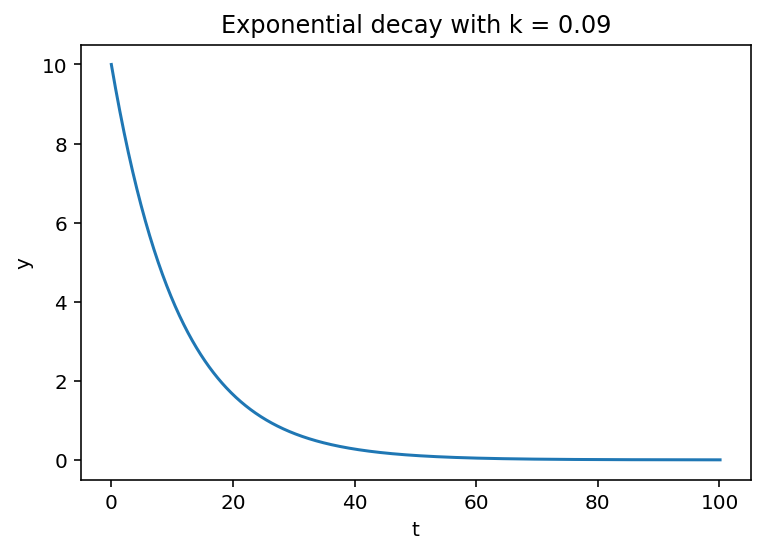

In [59]:
#Plot
plt.plot(t, y)
plt.title("Exponential decay with k = %.2f" %k) #string formatting magic
plt.xlabel("t")
plt.ylabel("y")

## Example for population:

In [60]:
def network(t, y, Wr, Wi, F):
    #scipy solver takes input as a single vector.
    # We want output as two vectors so we split y in half
    n = int(len(y) / 2)
    x = y[:n]
    v = y[n:]
    
    #Constant parameters
    b = 1
    a = .25
    
    #Differential equation part
    dxdt = v
    #np.dot is dot product or matrix multiplication depending on context
    dvdt = -a*x -b*v + np.dot(Wr, np.tanh(x)) + np.dot(Wi, F(t)) 
    
    #Since we split y in half we have to concatenate dxdt and dvdt 
    # into single vector
    f = np.array([dxdt, dvdt]).flatten()
    return(f)

In [61]:
#Population size
N = 100 

#Initial conditions
t0 = 0
#2 columns of length N for actual and perceived happiness
y0 = np.random.randn(2, N).flatten() #flattened to pass to solver

#Simulation end time and delta time
t1 = 100
dt = .1

#model parameters/arguments
#Asymmetric sparse random interaction weights
Wr = scipy.sparse.random(N, N, .03, data_rvs=np.random.randn).A
#first two params to size (square)
#third corresponds to sparsity
#fourth to type of random variable, in this case normal

np.fill_diagonal(Wr, 0)
#no self interactio

#Random connecivity to forcing function
Wi = np.random.randn(N)

#Forcing function.
def F(t):
    if t > 50 and t < 51:
        return 1
    if t > 70 and t < 75:
        return np.cos(np.pi*t)
    else:
        return 0

r = ode(network)
r.set_initial_value(y0, t0).set_f_params(Wr, Wi, F) #parameters in order
#note function F can be passed as a parameter! F is called inside the solver


#Loop through ode solver and get values as you go
t = [t0]
y = [y0]

#r.successful ensures ode does not blow up
# r.t < t1 sets maximmum simulation length
while r.successful() and r.t < t1: 
    #t.t + dt is current time + dt
    r.integrate(r.t+dt)
    #record output t and y
    t.append(r.t)
    y.append(r.y)

#Each row of y corresponds to a time step

In [62]:
y = np.array(y) #cast y which is a python list into a numpy array
y = y.reshape(-1, 2, N).transpose(0,2,1) #reshape into two columns 
#and reorder dimensions. If you want to replicate something like this
#either talk me or use trial and error because I found this dimension 
#switching very confusing
#this makes the first axis correspond to time step, 
#the second axis to individual,
#the third axis to actual or perceived happiness

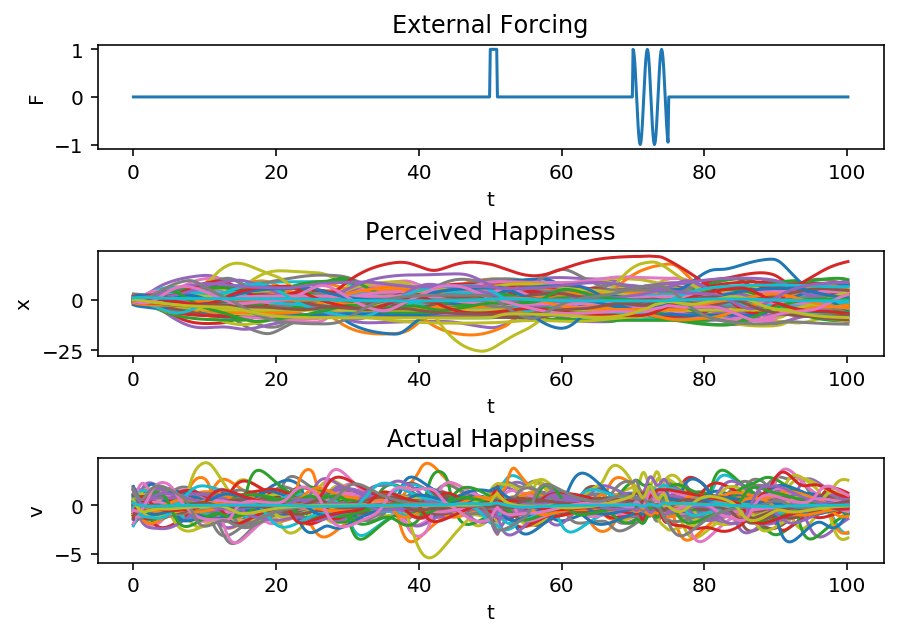

In [63]:
#Modified plotting syntax for subplots
fig, axes = plt.subplots(3, 1)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=3.0)

axes[0].plot(t, [F(ti) for ti in t])
axes[0].set_title('External Forcing')
axes[0].set_ylabel('F')
axes[0].set_xlabel('t')

axes[1].plot(t, y[:, :, 0])
axes[1].set_title('Perceived Happiness')
axes[1].set_ylabel('x')
axes[1].set_xlabel('t')

axes[2].plot(t, y[:, :, 1])
axes[2].set_title('Actual Happiness')
axes[2].set_ylabel('v')
axes[2].set_xlabel('t')
    
    

# Animation

'G' is an object representing the graph of connected nodes and edges.
It is uniquely specified by a connectivity matrix Wr which is not necessarily symmetric.

In [161]:
G=nx.from_numpy_matrix(Wr) #Wr defined above as interaction weights

'data' is matrix which animates the nodes. rows correspond to individuals and columns correspond to time stamps

In [ ]:
data = y[:,:,1] #0 for perceived, 1 for actual happiness

'title' corresponds to the animation title

In [ ]:
title = "Sparse Random Connectivity"

The actual animation code. You will likely not need to change this. I still need to tweak this to label the color bar 

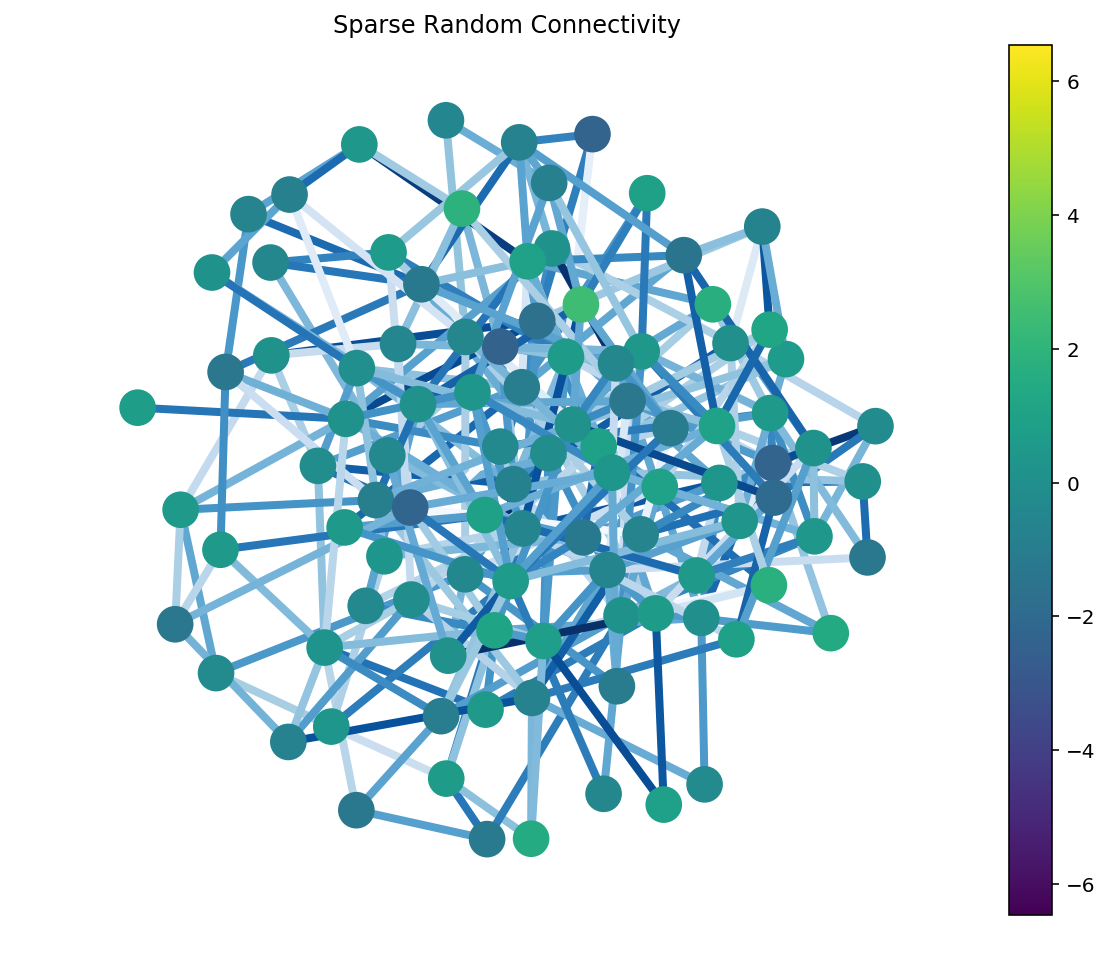

In [162]:
pos=nx.spring_layout(G, iterations = 1000, weight=None)

edge_colors = [g[2]["weight"] for g in G.edges(data=True)]
edge_cmap=plt.cm.Blues

node_colors = data[0]
node_cmap = plt.cm.viridis
vmin = np.min(data)
vmax = np.max(data)
norm=plt.Normalize(vmin=vmin, vmax=vmax)

fig = plt.figure(figsize=(10,8))


nodes = nx.draw_networkx_nodes(
        G,pos,                        
        node_color=node_colors, node_cmap=node_cmap
    )

nx.draw_networkx_edges(
    G,pos,
    edge_color=edge_colors,width=4,edge_cmap=edge_cmap
)
plt.axis('off')

sm = plt.cm.ScalarMappable(cmap=node_cmap, norm=norm)
sm._A = []
plt.colorbar(sm)
plt.title(title)

def update(i):
    node_colors = node_cmap(norm(data[i]))
    nodes.set_color(node_colors)
    
anim = animation.FuncAnimation(fig, update, frames = range(0, len(data), 2), interval=15)

anim